# Reading in Data

In [45]:
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
import math
import importlib
import mcmc_functions
importlib.reload(mcmc_functions)

from mcmc_functions import *
import importlib

seasons_missing_df = pd.read_csv('/Users/josephsun/Desktop/M4R/code/premier-league-matches.csv')
tables_df = pd.read_csv('/Users/josephsun/Desktop/M4R/code/pl-tables-1993-2024.csv')
recent_df = pd.read_csv('matches.csv')
recent_df = recent_df[recent_df['Venue'] == 'Home']

In [46]:
converted_recent_df = convert_match_data(recent_df)
converted_recent_df = converted_recent_df.sort_values(by='Wk').reset_index(drop=True)

seasons_df = pd.concat([seasons_missing_df, converted_recent_df], ignore_index=True)

recent = seasons_df[seasons_df['Season_End_Year'] == 2023] #2023 season
recent_previous = seasons_df[seasons_df['Season_End_Year'] == 2022]
initial_season = seasons_df[seasons_df['Season_End_Year'] == 1993]

In [47]:
seasons_df[seasons_df['Season_End_Year'] == 2023]

,Season_End_Year,Wk,Date,Home,HomeGoals,AwayGoals,Away,FTR
11646,2023,1,2022-08-05,Crystal Palace,0,2,Arsenal,A
11647,2023,1,2022-08-06,Fulham,2,2,Liverpool,D
11648,2023,1,2022-08-06,Tottenham,4,1,Southampton,H
11649,2023,1,2022-08-06,Newcastle Utd,2,0,Nott'ham Forest,H
11650,2023,1,2022-08-06,Leeds United,2,1,Wolves,H
...,...,...,...,...,...,...,...,...
12021,2023,38,2023-05-28,Everton,1,0,Bournemouth,H
12022,2023,38,2023-05-28,Leicester City,2,1,West Ham,H
12023,2023,38,2023-05-28,Aston Villa,2,1,Brighton,H
12024,2023,38,2023-05-28,Leeds United,1,4,Tottenham,A


In [48]:
recent = seasons_df[seasons_df['Season_End_Year'] == 2024]
#Premier League initally started with 22 teams, 42 matches/team. Reduced to 20 teams, 38 matches/team in 1995/96 season
#Project Restart - 19 May 2020. Fans allowed back in May 2021. Can potentially use this period to investigate home advantage
recent

,Season_End_Year,Wk,Date,Home,HomeGoals,AwayGoals,Away,FTR
12026,2024,1,2023-08-14,ManchesterUnited,1,0,Wolves,H
12027,2024,1,2023-08-12,Arsenal,2,1,Nott'ham Forest,H
12028,2024,1,2023-08-12,SheffieldUnited,0,1,Crystal Palace,A
12029,2024,1,2023-08-11,Burnley,0,3,Manchester City,A
12030,2024,1,2023-08-13,Chelsea,1,1,Liverpool,D
...,...,...,...,...,...,...,...,...
12401,2024,38,2024-05-19,Liverpool,2,0,Wolves,H
12402,2024,38,2024-05-19,Arsenal,2,1,Everton,H
12403,2024,38,2024-05-19,ManchesterCity,3,1,West Ham,H
12404,2024,38,2024-05-19,Burnley,1,2,Nott'ham Forest,A


In [49]:
results_df = seasons_df.groupby('Season_End_Year')['FTR'].value_counts().unstack(fill_value=0)
#table containing number of away wins, home wins, draws for each season
results_df

FTR,A,D,H
Season_End_Year,,,
1993,118,130,214
1994,128,142,192
1995,123,134,205
1996,96,98,186
1997,99,119,162
1998,101,95,184
1999,96,115,169
2000,101,92,187
2001,95,101,184


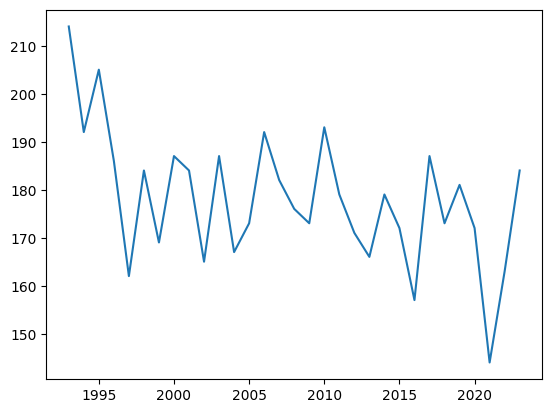

In [6]:
plt.plot(results_df['H'])

In [51]:
seasons_df.columns

Index(['Season_End_Year', 'Wk', 'Date', 'Home', 'HomeGoals', 'AwayGoals',
       'Away', 'FTR'],
      dtype='object')

In [153]:
def goal_summary(df, start_year, end_year, max_goals=4):
    df_all = df[(df['Season_End_Year'] >= start_year) & (df['Season_End_Year'] <= end_year)]
    total_matches = len(df_all)

    # Print average goals
    avg_home_goals = df_all['HomeGoals'].mean()
    avg_away_goals = df_all['AwayGoals'].mean()
    print(f"Average Home Goals: {avg_home_goals:.2f}")
    print(f"Average Away Goals: {avg_away_goals:.2f}")

    # Compute marginals over full data
    away_dist = df_all['AwayGoals'].value_counts(normalize=True).sort_index()
    home_dist = df_all['HomeGoals'].value_counts(normalize=True).sort_index()

    # Build the display subset: only goals within range for table output
    table_data = []
    ratio_data = []

    for h in range(max_goals + 1):
        row = []
        ratio_row = []
        for a in range(max_goals + 1):
            p_joint = ((df_all['HomeGoals'] == h) & (df_all['AwayGoals'] == a)).sum() / total_matches
            se_joint = np.sqrt(p_joint * (1 - p_joint) / total_matches)
            row.append(f"{p_joint * 100:.1f} ({se_joint * 100:.2f})")

            p_expected = home_dist.get(h, 0) * away_dist.get(a, 0)
            ratio = p_joint / p_expected if p_expected > 0 else np.nan
            se_ratio = se_joint / p_expected if p_expected > 0 else np.nan

            ratio_row.append(f"{ratio:.2f} ({se_ratio:.2f})" if p_expected > 0 else "NA")
        table_data.append(row)
        ratio_data.append(ratio_row)

    # Marginals
    home_marginals = [
        f"{home_dist.get(h, 0) * 100:.1f} ({np.sqrt(home_dist.get(h, 0) * (1 - home_dist.get(h, 0)) / total_matches) * 100:.2f})"
        for h in range(max_goals + 1)
    ]
    away_marginals = [
        f"{away_dist.get(a, 0) * 100:.1f} ({np.sqrt(away_dist.get(a, 0) * (1 - away_dist.get(a, 0)) / total_matches) * 100:.2f})"
        for a in range(max_goals + 1)
    ]

    # Create main DataFrame
    prob_df = pd.DataFrame(table_data, index=range(max_goals + 1), columns=range(max_goals + 1))
    prob_df.insert(0, "", home_marginals)
    prob_df.columns = pd.MultiIndex.from_arrays([
        ["", "Away Goals"] + [""] * max_goals,
        ["Home Goals"] + list(range(max_goals + 1))
    ])
    prob_df = pd.concat([pd.DataFrame([[""] + away_marginals], columns=prob_df.columns), prob_df], ignore_index=True)
    prob_df.index = [""] + list(range(max_goals + 1))

    # Ratio DataFrame
    ratio_df = pd.DataFrame(ratio_data, index=range(max_goals + 1), columns=range(max_goals + 1))
    ratio_df.insert(0, "", home_marginals)
    ratio_df.columns = pd.MultiIndex.from_arrays([
        ["", "Away Goals"] + [""] * max_goals,
        ["Home Goals"] + list(range(max_goals + 1))
    ])
    ratio_df = pd.concat([pd.DataFrame([[""] + away_marginals], columns=ratio_df.columns), ratio_df], ignore_index=True)
    ratio_df.index = [""] + list(range(max_goals + 1))

    return prob_df, ratio_df


In [154]:
goal_summary(seasons_df, 2015, 2024, max_goals = 5)[0] 

Average Home Goals: 1.55
Average Away Goals: 1.25


Away Goals                                                    \
    Home Goals            0            1            2           3           4   
                31.8 (0.76)  33.2 (0.76)  20.5 (0.65)  9.6 (0.48)  3.5 (0.30)   
0  23.2 (0.69)   6.6 (0.40)   7.2 (0.42)   4.9 (0.35)  2.7 (0.26)  1.2 (0.17)   
1  31.9 (0.76)   9.4 (0.47)  10.5 (0.50)   6.9 (0.41)  3.2 (0.28)  1.4 (0.19)   
2  24.0 (0.69)   8.0 (0.44)   8.0 (0.44)   5.2 (0.36)  2.0 (0.23)  0.6 (0.12)   
3  12.7 (0.54)   4.4 (0.33)   4.8 (0.35)   2.3 (0.24)  0.9 (0.16)  0.2 (0.07)   
4   5.3 (0.36)   2.1 (0.23)   1.7 (0.21)   0.9 (0.15)  0.5 (0.11)  0.1 (0.05)   
5   2.1 (0.23)   1.1 (0.17)   0.6 (0.12)   0.2 (0.08)  0.1 (0.06)  0.1 (0.04)   

               
            5  
   1.0 (0.16)  
0  0.4 (0.10)  
1  0.4 (0.10)  
2  0.2 (0.07)  
3  0.0 (0.00)  
4  0.0 (0.03)  
5  0.0 (0.00)

In [148]:
final, ratio = goal_summary(seasons_df, 2015, 2024, max_goals = 4) 

In [149]:
final

Away Goals                                                  
    Home Goals            0            1            2           3           4
                31.8 (0.76)  33.2 (0.76)  20.5 (0.65)  9.6 (0.48)  3.5 (0.30)
0  23.2 (0.69)   6.6 (0.40)   7.2 (0.42)   4.9 (0.35)  2.7 (0.26)  1.2 (0.17)
1  31.9 (0.76)   9.4 (0.47)  10.5 (0.50)   6.9 (0.41)  3.2 (0.28)  1.4 (0.19)
2  24.0 (0.69)   8.0 (0.44)   8.0 (0.44)   5.2 (0.36)  2.0 (0.23)  0.6 (0.12)
3  12.7 (0.54)   4.4 (0.33)   4.8 (0.35)   2.3 (0.24)  0.9 (0.16)  0.2 (0.07)
4   5.3 (0.36)   2.1 (0.23)   1.7 (0.21)   0.9 (0.15)  0.5 (0.11)  0.1 (0.05)

In [150]:
print(final.to_latex(escape = False))

\begin{tabular}{lllllll}
\toprule
 &  & Away Goals & \multicolumn{4}{r}{} \\
 & Home Goals & 0 & 1 & 2 & 3 & 4 \\
\midrule
 &  & 31.8 (0.76) & 33.2 (0.76) & 20.5 (0.65) & 9.6 (0.48) & 3.5 (0.30) \\
0 & 23.2 (0.69) & 6.6 (0.40) & 7.2 (0.42) & 4.9 (0.35) & 2.7 (0.26) & 1.2 (0.17) \\
1 & 31.9 (0.76) & 9.4 (0.47) & 10.5 (0.50) & 6.9 (0.41) & 3.2 (0.28) & 1.4 (0.19) \\
2 & 24.0 (0.69) & 8.0 (0.44) & 8.0 (0.44) & 5.2 (0.36) & 2.0 (0.23) & 0.6 (0.12) \\
3 & 12.7 (0.54) & 4.4 (0.33) & 4.8 (0.35) & 2.3 (0.24) & 0.9 (0.16) & 0.2 (0.07) \\
4 & 5.3 (0.36) & 2.1 (0.23) & 1.7 (0.21) & 0.9 (0.15) & 0.5 (0.11) & 0.1 (0.05) \\
\bottomrule
\end{tabular}



In [151]:
ratio

Away Goals                                         \
    Home Goals            0            1            2            3   
                31.8 (0.76)  33.2 (0.76)  20.5 (0.65)   9.6 (0.48)   
0  23.2 (0.69)  0.89 (0.05)  0.94 (0.05)  1.03 (0.07)  1.23 (0.12)   
1  31.9 (0.76)  0.92 (0.05)  0.99 (0.05)  1.06 (0.06)  1.04 (0.09)   
2  24.0 (0.69)  1.05 (0.06)  1.01 (0.06)  1.05 (0.07)  0.87 (0.10)   
3  12.7 (0.54)  1.09 (0.08)  1.15 (0.08)  0.87 (0.09)  0.78 (0.13)   
4   5.3 (0.36)  1.22 (0.14)  0.99 (0.12)  0.80 (0.14)  0.99 (0.23)   

                
             4  
    3.5 (0.30)  
0  1.42 (0.21)  
1  1.27 (0.17)  
2  0.69 (0.15)  
3  0.48 (0.17)  
4  0.43 (0.25)

In [152]:
print(ratio.to_latex(escape = False))

\begin{tabular}{lllllll}
\toprule
 &  & Away Goals & \multicolumn{4}{r}{} \\
 & Home Goals & 0 & 1 & 2 & 3 & 4 \\
\midrule
 &  & 31.8 (0.76) & 33.2 (0.76) & 20.5 (0.65) & 9.6 (0.48) & 3.5 (0.30) \\
0 & 23.2 (0.69) & 0.89 (0.05) & 0.94 (0.05) & 1.03 (0.07) & 1.23 (0.12) & 1.42 (0.21) \\
1 & 31.9 (0.76) & 0.92 (0.05) & 0.99 (0.05) & 1.06 (0.06) & 1.04 (0.09) & 1.27 (0.17) \\
2 & 24.0 (0.69) & 1.05 (0.06) & 1.01 (0.06) & 1.05 (0.07) & 0.87 (0.10) & 0.69 (0.15) \\
3 & 12.7 (0.54) & 1.09 (0.08) & 1.15 (0.08) & 0.87 (0.09) & 0.78 (0.13) & 0.48 (0.17) \\
4 & 5.3 (0.36) & 1.22 (0.14) & 0.99 (0.12) & 0.80 (0.14) & 0.99 (0.23) & 0.43 (0.25) \\
\bottomrule
\end{tabular}

